# BigG_EXPRESS PROJECT

**Note conda activate mypycaret in prompt then open notebook to run the cells, it has issue running lot of other packages so they need to be coda installed**
**So I will do the basic EDA and data prep for machine learning then save it to csv and read that csv in pycaret environment for prediction**
**If running in base environment then markdown pycaret import**

### **This is exploration of the BigG (Trucking company dataset). The trucks have a complete stop if they have the spn-code of 5246, spn-1569 and fmi 31 is 75% derate. The objectiv eis to figure out the spn/fmi codde combination withi 3-6 hour window to call the truck from the road and save the cost of toweing and have the delivery on time using alternative.**

**Data code**
**QCVehDiagOnboardData –**
 
Id -  the record Id
Name – the name of the diagnostic
Value – the value for that diagnostic
FaultId – foreign key to the QCJ1939Fault record

 
These are the engine data parameters that are sent with the engine faults.
 
**QCJ1939Fault –**
 
**ESS_Id** – the event subscriber service event that contained the fault
**EventTimeStamp** – when the event took place
**eventDescription** – brief text of meaning of the code (not always present)
**actionDescription** – never seen this filled in
**ecuSoftwareVersion** – version string from the reporting vehicle computer system
**ecuSerialNumber** – Serial number of the reporting Engine Control Module (ECM)
**ecuModel** -Model of the reporting ECM
**ecuMake** – Manufacturer of the reporting ECM
**ecuSource** –
**spn** – Fault code being reported
**fmi** – Failure Mode associated with the Fault Code
**active**– whether the code is being set or being removed
**activeTransitionCount** – Number of times code has been set/unset
**faultValue** – never seen used
**EquipmentID** – Assigned truck number of the unit in question
**MCTNumber**– Communications Terminal assigned to the truck
**Latitude** – Latitude at time of event
**Longitude** – Longitude at time of event
**LocationTimeStamp** – Time latitude and longitude were obtained


In [1]:
#Libraries need for work

import pandas as pd
from datetime import datetime



from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

#we need to create a conda environment for pycaret and then pip install the packages after activating and rerun the notebook.
# from pycaret.classification import *
# from pycaret.regression import *
# from pycaret.time_series import *

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
# conda install openpyxl

In [3]:
#Reading the data files

faults = pd.read_csv("../data/J1939Faults.csv",low_memory=False,
                     parse_dates=['EventTimeStamp', 'LocationTimeStamp'])
    #initial reading we saw it has date time object so we will keep them as date time. 
    #Also we saw the waning for memmory because of which we were loosing observations, so we will have low_memmory =False

diagnostic = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")
service = pd.read_excel("../data/Service Fault Codes_1_0_0_167.xlsx")

C:\Users\upadh\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


**Looking for data structure in the read csv**

In [22]:
print(faults.shape) #(1187335, 20)
print(diagnostic.shape) #(12821626, 4)
print(service.shape) #(7124, 14)

(1187335, 20)
(12821626, 4)
(7124, 14)


In [5]:
faults.head(2)

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25
1,2,990360,2015-02-21 11:34:34,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10


In [6]:
faults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   RecordID               1187335 non-null  int64         
 1   ESS_Id                 1187335 non-null  int64         
 2   EventTimeStamp         1187335 non-null  datetime64[ns]
 3   eventDescription       1126490 non-null  object        
 4   actionDescription      0 non-null        float64       
 5   ecuSoftwareVersion     891285 non-null   object        
 6   ecuSerialNumber        844318 non-null   object        
 7   ecuModel               1122577 non-null  object        
 8   ecuMake                1122577 non-null  object        
 9   ecuSource              1187335 non-null  int64         
 10  spn                    1187335 non-null  int64         
 11  fmi                    1187335 non-null  int64         
 12  active                 11873

In [7]:
faults.describe()
faults.isna().sum()

RecordID                       0
ESS_Id                         0
EventTimeStamp                 0
eventDescription           60845
actionDescription        1187335
ecuSoftwareVersion        296050
ecuSerialNumber           343017
ecuModel                   64758
ecuMake                    64758
ecuSource                      0
spn                            0
fmi                            0
active                         0
activeTransitionCount          0
faultValue               1187335
EquipmentID                    0
MCTNumber                      0
Latitude                       0
Longitude                      0
LocationTimeStamp              0
dtype: int64

<Axes: title={'center': 'Observations_per_year'}, ylabel='Number of Observations'>

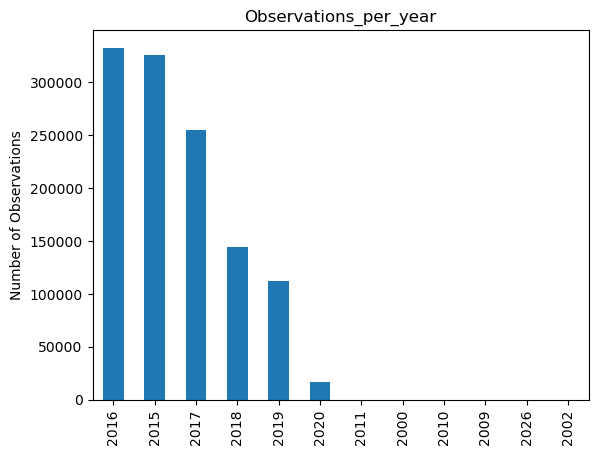

In [8]:
faults.columns
faults['EventTimeStamp'].value_counts()
(faults['EventTimeStamp']
 .dt.year
 .value_counts()
 .sort_values(ascending = False)
 .plot(kind="bar", 
       title = 'Observations_per_year',
       xlabel='', ylabel='Number of Observations'))
#date time has year dt.year extracts year from it

<Axes: title={'center': 'Observations_per_year'}, xlabel='Years in EventTimeStamp', ylabel='# of events'>

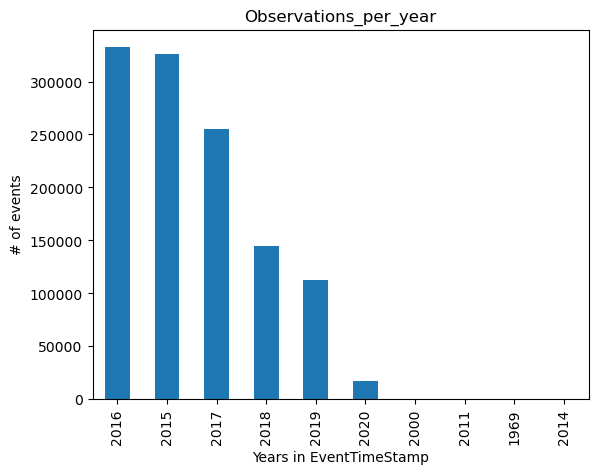

In [9]:
(faults['LocationTimeStamp']
 .dt.year
 .value_counts()
 .sort_values(ascending = False)
 .plot(kind="bar", 
       title = 'Observations_per_year',
        xlabel='Years in EventTimeStamp',
       ylabel='# of events'))
#date time has year dt.year extracts year from it

<Axes: title={'center': 'Observations_per_year'}, xlabel='Years in LocationTimeStamp', ylabel='# of events'>

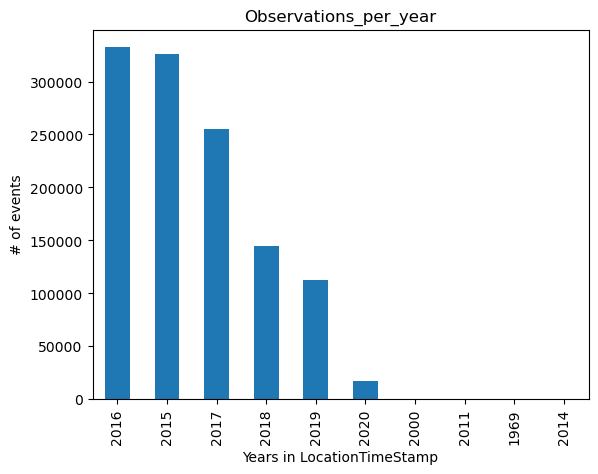

In [10]:
faults['EventTimeStamp'].dt.year.unique()
faults['EventTimeStamp'].dt.year.value_counts()
(faults['LocationTimeStamp'].dt.year.value_counts()
 .sort_values(ascending = False)
 .plot(kind="bar", 
       title = 'Observations_per_year',
       xlabel='Years in LocationTimeStamp',
       ylabel='# of events'))

<Axes: title={'center': 'Equipment_Id'}, ylabel='Number of Observations'>

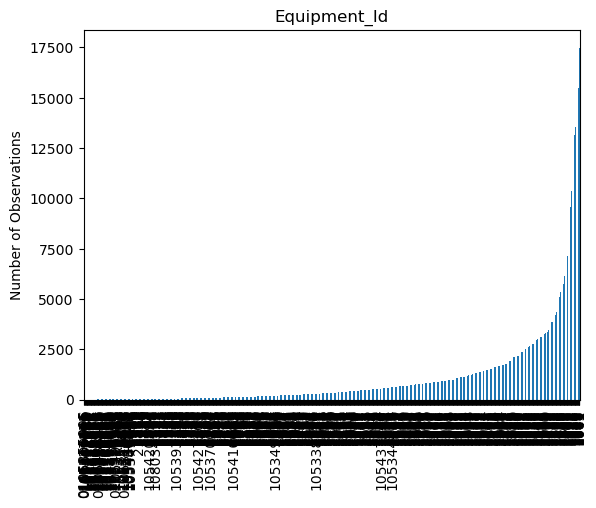

In [11]:
faults['EquipmentID'].nunique() #1122
(faults['EquipmentID'].value_counts().sort_values()
 .plot(kind="bar", 
       title = 'Equipment_Id',
       xlabel= (''),
       ylabel='Number of Observations'))

In [12]:
#the EuipmentId is a string character and has length varrying from character lnrth 3 4, 5, and 9 and 10
faults['EquipmentID'].str.len().nunique() #5
faults['EquipmentID'].str.len().value_counts().sort_values(ascending=False).to_frame()


,EquipmentID
4,1158964
3,26179
9,2150
5,23
10,19


<Axes: title={'center': 'Equipment_Id'}, ylabel='Number of Observations'>

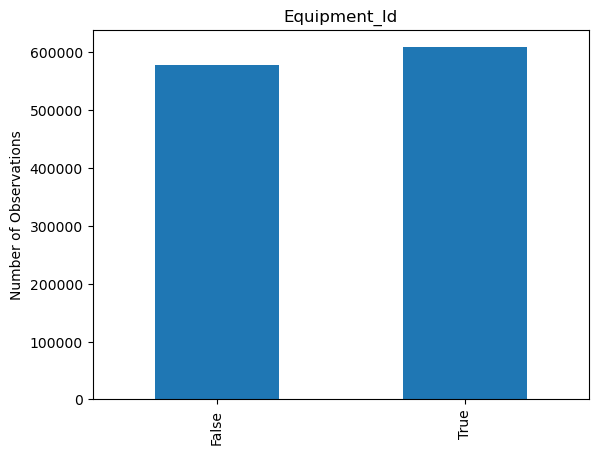

In [51]:
(faults['active'].value_counts().sort_values()
 .plot(kind="bar", 
       title = 'Equipment_Id',
       xlabel= (''),
       ylabel='Number of Observations'))

In [14]:
faults['spn'].nunique() #450
faults['fmi'].nunique() #26
faults[(faults['spn'] == 1569)].shape #10927 observations o
faults[(faults['spn'] == 5246)].shape #1195 observations

faults['EquipmentID'].value_counts()
# faults.groupby('EquipmentID')[(faults['spn']==1569)].sum()
faults['EquipmentID'].nunique() #1122
faults.loc[faults['spn']==1569]['EquipmentID'].value_counts().to_frame() #506 trucks
faults.loc[faults['spn']==5246]['EquipmentID'].value_counts().to_frame() #215 trucks
faults.loc[(faults['spn']==5246) | (faults['spn']==1569)]['EquipmentID'].value_counts().to_frame() #535
faults[(faults['spn'].isin([1569, 5246]))]['EquipmentID'].value_counts().to_frame()

faults[(faults['spn'].isin([1569, 5246]))].groupby('EquipmentID').value_counts().to_frame()
#giving null values not sure why???

,,,,,,,,,,,,,,,,,,,,0
EquipmentID,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,MCTNumber,Latitude,Longitude,LocationTimeStamp,


<Axes: title={'center': 'fmi distribution when spn=5246'}, xlabel='fmi', ylabel='# of events'>

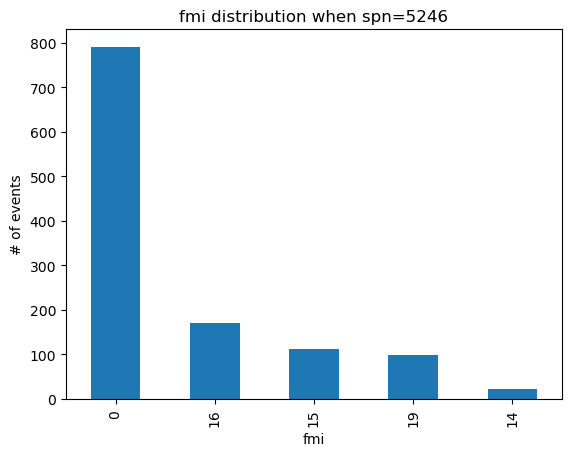

In [15]:
(faults[(faults['spn'] == 5246)]['fmi'].value_counts().sort_values(ascending = False)
 .plot(kind="bar", 
       title = 'fmi distribution when spn=5246',
       xlabel='fmi',
       ylabel='# of events'))

**SUMMARY faults df:**

It has 1187335 (1.18 X10^6) obseravtions and 20 features.
The columns are ['RecordID', 'ESS_Id', 'EventTimeStamp', 'eventDescription',
       'actionDescription', 'ecuSoftwareVersion', 'ecuSerialNumber',
       'ecuModel', 'ecuMake', 'ecuSource', 'spn', 'fmi', 'active',
       'activeTransitionCount', 'faultValue', 'EquipmentID', 'MCTNumber',
       'Latitude', 'Longitude', 'LocationTimeStamp']
We have following structure two datetime (EventTimeStamp,  LocationTimeStamp), Object (ecuSoftwareVersion,ecuSerialNumber, ecuModel,  ecuMake, EquipmentID )
we have 4 floats including Latitite and Longitude but the actionDescription and faultValue  are all null 
**so we will drop actionDescription and faultValue columns.**
Rest are all int64.

0   RecordID               1187335 non-null  int64         
 1   ESS_Id                 1187335 non-null  int64         
 2   EventTimeStamp         1187335 non-null  datetime64[ns]
 3   eventDescription       1126490 non-null  object        
 4   actionDescription      0 non-null        float64       
 5   ecuSoftwareVersion     891285 non-null   object        
 6   ecuSerialNumber        844318 non-null   object        
 7   ecuModel               1122577 non-null  object        
 8   ecuMake                1122577 non-null  object        
 9   ecuSource              1187335 non-null  int64         
 10  spn                    1187335 non-null  int64         
 11  fmi                    1187335 non-null  int64         
 12  active                 1187335 non-null  bool          
 13  activeTransitionCount  1187335 non-null  int64         
 14  faultValue             0 non-null        float64       
 15  EquipmentID            1187335 non-null  object        
 16  MCTNumber              1187335 non-null  int64         
 17  Latitude               1187335 non-null  float64       
 18  Longitude              1187335 non-null  float64       
 19  LocationTimeStamp      1187335 non-null  datetime64[ns]
    
The event starts at **[ 2000, 2002, 2009,2010, 2011, 2015, 2016, 2017, 2018, 2019,  2020, 2026]**,
but the 2011(244),2000(219),2010(58), 2009(24),2026(3),2002(1) have a total of 541 observations. 

**in the LocationTimeStamp we also have 2014(1),2000(192), 2011(8), 1969(2)
**So we will drop the years below 2014.**

We have a total of 1122 unique EquipmentID. The string character is of 5 different length most observations are of string character of 3 and 4 there are also some 5 but then we have 9 and 10.
As mentioned by the BigG  **we will drop the id which more than 5 character.**

The lat and long column will be used for finding how close the truck is one of the three servce stations.
**One degree of latitude equals approximately 364,000 feet (69 miles). One-degree of longitude equals 288,200 feet (54.6 miles)**
so **we will drop those observations which are within 1 mile radii of the service station.**

Also the **active** code which are **False** means that the fault code is fixed so we will also drop those rows.
The lat long of the three stations are also provided.

There 450 uniues spn codes.

In [26]:
faults[(faults['spn'] == 1569) & (faults['fmi'] == 31)]['EquipmentID'].nunique() #506
faults[(faults['spn'] == 1569) & (faults['spn'] == 5246)]['EquipmentID'].nunique() #0 Not sure why this is not working??
#for example truck 1872 has both spn code as shown below.
faults[faults['EquipmentID']=='1872']['spn'].value_counts().to_frame().reset_index().rename(columns={'index':'spn',
                                                                                                    'spn': 'counts'})

,spn,counts
0,1761,53
1,3364,20
2,3031,18
3,3216,18
4,5742,16
5,96,16
6,5743,15
7,630,14
8,3226,14
9,5835,13


In [30]:
faults.loc[~(faults['spn'].isin([1569, 5426]))] #1176408 rows × 20 columns
faults.loc[(faults['spn'].isin([1569, 5426]))] #10927 rows × 20 columns
faults.loc[(faults['spn'].isin([1569, 5426]))]['EquipmentID'].nunique() #506
# faults[(faults['spn'].isin([1569, 5246]))].groupby('EquipmentID').value_counts() #this keeps giving zero

Series([], dtype: int64)

## ***Cleaning the faults the df***
### 1. drop rows within 0.01 mile of servic station
### 2. drop rows with the EuipmentID more than 5 charcter long
### 3. drop rows where the EventTimeStamp less than 2011.
### 4. drop the rows with 'active' code as "False" as the error is fixed.
### 5. drop the two columns actionDescription and faultValue which are all nan

In [44]:
#to retain the original faults going to make a copy
faults_clean = faults.copy()
faults_clean.shape #(1187335, 20)

(1187335, 20)

In [45]:
#finding the distance from the nearest service stations.
#using abs for absolute values so that we can negate 0.01 without having to worry about negative and positive values.
faults_clean['latA_diff'] = abs(faults_clean['Latitude']-36.0666667)
faults_clean['latB_diff'] = abs(faults_clean['Latitude']-35.5883333)
faults_clean['latC_diff'] = abs(faults_clean['Latitude']-36.1950)
faults_clean['longA_diff'] = abs(faults_clean['Longitude']-(-86.4347222))
faults_clean['longB_diff'] = abs(faults_clean['Longitude']-(-86.4438888))
faults_clean['longC_diff'] = abs(faults_clean['Longitude']-(-83.174722))

faults_clean #1187335 rows × 26 columns

#abs() gives the result as absolute number
# now drop the rows which have values less than 0.01, meaning in proximity of the service station.


,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,...,MCTNumber,Latitude,Longitude,LocationTimeStamp,latA_diff,latB_diff,latC_diff,longA_diff,longB_diff,longC_diff
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,...,105354361,38.857638,-84.626851,2015-02-21 11:34:25,2.790971,3.269305,2.662638,1.807871,1.817038,1.452129
1,2,990360,2015-02-21 11:34:34,NaN,NaN,unknown,unknown,unknown,unknown,11,...,105354361,38.857638,-84.626851,2015-02-21 11:35:10,2.790971,3.269305,2.662638,1.807871,1.817038,1.452129
2,3,990364,2015-02-21 11:35:31,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,...,105336226,41.421250,-87.767361,2015-02-21 11:35:26,5.354583,5.832917,5.226250,1.332639,1.323472,4.592639
3,4,990370,2015-02-21 11:35:33,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,...,105336226,41.421018,-87.767361,2015-02-21 11:36:08,5.354351,5.832685,5.226018,1.332639,1.323472,4.592639
4,5,990416,2015-02-21 11:39:41,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,...,105427130,38.416481,-89.442638,2015-02-21 11:39:37,2.349814,2.828148,2.221481,3.007916,2.998749,6.267916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,...,105439740,37.094768,-85.897407,2020-03-06 14:00:21,1.028101,1.506435,0.899768,0.537315,0.546482,2.722685
1187331,1248455,123905139,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,...,105354084,34.390740,-79.461805,2020-03-06 14:04:59,1.675927,1.197593,1.804260,6.972917,6.982084,3.712917
1187332,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,...,105336308,34.430370,-84.920509,2020-03-06 14:14:14,1.636297,1.157963,1.764630,1.514213,1.523380,1.745787
1187333,1248457,123906113,2020-03-06 14:14:13,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,...,108605700,35.030925,-85.321527,2020-03-06 14:14:49,1.035742,0.557408,1.164075,1.113195,1.122362,2.146805


In [46]:
#droping the record that happens to be in proximity to any three service stations (0.01 miles)
#droping the record that happens to be in proximity to any three service stations (0.01 miles)
faults_clean = (faults_clean.loc[((faults_clean['latA_diff']) > 0.01) &
            ((faults_clean['latB_diff']) > 0.01) &
            ((faults_clean['latC_diff']) > 0.01) &
            ((faults_clean['longA_diff']) > 0.01) &
            ((faults_clean['longB_diff']) > 0.01) &
            ((faults_clean['longC_diff']) > 0.01)]
).drop(['latA_diff', 'latB_diff', 'latC_diff', 'longA_diff', 'longB_diff', 'longC_diff'], axis=1)

# I am left with (1032324 rows × 20 columns) by dropping 155011 rows and we need to fix & to or(|) as we need to drop only 131778 rows.

In [54]:
## this is bound to change once the 0.01 distance code is fixed
1187335 - 1032324 #droped 155011 rows
1187335 - 1187317 #droped 18 rows
1187335 -1107478 #droped 79857 rows
1187335 - 1159904 #droped 27431 rows
# latA and lonA =1069285 rows × 26 columns
# latA or lon A =1107478 rows × 26 columns
# latB or lonB =1162845 rows × 26 columns
# latC or lonC =1159904 rows × 26 columns
# latA|lonA & latB|lonB = 1129014 rows × 26 columns

1032324-1031930 #droped 394 rows
1031930-1030202 #droped 1728 rows
1030202-533202 #droped 497000 rows

497000

In [47]:
#dropping the rows with time before 2011: left with 1031930 rows × 20 columns)rows droped 394 rows.
#Also dropped the columns with all NaN.

faults_clean = (faults_clean.loc[faults_clean['EventTimeStamp'].dt.year > 2011]
                .drop(['actionDescription', 'faultValue'], axis=1))

In [50]:
#dropping the equipmentID longer than 5 character string now we have 1031930 rows we dropped 1728 rows.

faults_clean = faults_clean[faults['EquipmentID'].str.len() <= 5]

C:\Users\upadh\AppData\Local\Temp\ipykernel_4844\1765933909.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  faults_clean = faults_clean[faults['EquipmentID'].str.len() <= 5]


In [55]:
#dropping the rows were the active code is FALSE now we are left with 533202 rows × 18 columns

faults_clean = faults_clean.loc[(faults_clean['active']) != False]

In [56]:
faults_clean.loc[faults['spn'] == 1569]['fmi'].value_counts()

31    4922
Name: fmi, dtype: int64

In [57]:
faults_clean['EquipmentID'].nunique() #from the 1122 now we have 1041 trucks in the cleaned dataset.

1041

In [63]:
#making a copy of the faults_clean so that when we fix the above code with number of the rows.

faults_ready = faults_clean.copy()

In [101]:
#making the spn_fmi merged column for genrating dummies after merger with diagnostic

faults_ready['spn_fmi'] = ['_'.join(i) for i in zip(faults_ready['spn'].astype(str), faults_ready['fmi'].astype(str))]


In [102]:
#making other spn-fmi column which will be retained after .get dummies.
faults_ready['SPN_FMI'] = ['_'.join(i) for i in zip(faults_ready['spn'].astype(str), faults_ready['fmi'].astype(str))]

In [104]:
faults_ready #533202 rows × 20 columns
faults_ready.columns

Index(['RecordID', 'ESS_Id', 'EventTimeStamp', 'eventDescription',
       'ecuSoftwareVersion', 'ecuSerialNumber', 'ecuModel', 'ecuMake',
       'ecuSource', 'spn', 'fmi', 'active', 'activeTransitionCount',
       'EquipmentID', 'MCTNumber', 'Latitude', 'Longitude',
       'LocationTimeStamp', 'spn_fmi', 'SPN_FMI'],
      dtype='object')

#### Creating the dummy variables for the spn_fmi combination to generate features to predic when he derate is going to happen.
#### We will create a combined column for spn and fmi as spn_fmi and this will be converted to dummy using pd.get_dummies then recreate the spn_fmi column.
#### we also need the information for the events happened before derate/partial derate events so we will ceate the rolling cicle window for 6H.
#### But beffore that we will pivot the diagnostic and merge with the faults_clean so that we can impute the Nan values in 
#### the column after grouping with equipmentID, after rolling some trucks dont have info with in the rolling window so we can not impute the mean.
#### FaultId is unique and matches with the RecordID in faults



In [70]:
diagnostic.shape #(12821626, 4)
diagnostic.head(5)
diagnostic.info() #FaulltId and id are int while name and value are object 
diagnostic.columns #'Id', 'Name', 'Value', 'FaultId'
diagnostic['Name'].nunique() #24 names are there
diagnostic.isna().sum() #there are no null column
diagnostic['FaultId'].nunique() #1187335 same number as the observations in the faults table before cleaning.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821626 entries, 0 to 12821625
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   Id       int64 
 1   Name     object
 2   Value    object
 3   FaultId  int64 
dtypes: int64(2), object(2)
memory usage: 391.3+ MB


1187335

In [73]:
diagnostic.groupby('Name')['Value'].value_counts() 
#notice that there are ',' in the value column. This will craete problem when converting to numeric so we will have to clean it/

Name                Value
AcceleratorPedal    0        277162
                    100       54097
                    99.6       2845
                    0.4        1945
                    27.2       1911
                              ...  
TurboBoostPressure  46.11         1
                    48.43         1
                    49.01         1
                    63.22         1
                    7,25          1
Name: Value, Length: 1014695, dtype: int64

In [84]:
diagnostic['Value'].str.contains(',').sum() # there are a total of 304 rows which have ',' in the Value string
diagnostic['Name'].str.contains(',').sum() # 0 in Name column

0

In [78]:
diagnostic['Value'].astype(str).str.replace(',', '').str.contains(',').sum() #so all ',' are replaced.

0

In [85]:
#making a copy of diagnostic so that we can go back if needed
diag = diagnostic.copy()

In [86]:
#removing the ', from the diag

for col in diag.columns[:21]:
    diag[col] = diag[col].astype(str).str.replace(',', '')

In [87]:
diag.head(5)

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1


In [89]:
diag.groupby('Name')['Value'].value_counts() 
diag['Value'].str.contains(',').sum()

0

#looks like the diag df is read for pivot and we will change to numeric aftr pivoting as some Value column has True and False in addition o th digits for some Names.

In [109]:
diag_pivot = diag.pivot(columns='Name', index='FaultId', values= 'Value').reset_index()

In [110]:
diag_pivot.info() #there are 24 columns we which are object we will change to numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1187335 entries, 0 to 1187334
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype 
---  ------                     --------------    ----- 
 0   FaultId                    1187335 non-null  object
 1   AcceleratorPedal           531889 non-null   object
 2   BarometricPressure         585976 non-null   object
 3   CruiseControlActive        574916 non-null   object
 4   CruiseControlSetSpeed      576458 non-null   object
 5   DistanceLtd                585819 non-null   object
 6   EngineCoolantTemperature   586071 non-null   object
 7   EngineLoad                 585621 non-null   object
 8   EngineOilPressure          586244 non-null   object
 9   EngineOilTemperature       583912 non-null   object
 10  EngineRpm                  586921 non-null   object
 11  EngineTimeLtd              581366 non-null   object
 12  FuelLevel                  502795 non-null   object
 13  FuelLtd                    

In [111]:
diag_pivot.isna().sum() #there are a lot of Nan expcept the lampStatus, we will impute the missing values with mean of that truck after merging to faults and grouping by EquipmentID
diag_pivot.head()

Name,FaultId,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,0,14.21,False,66.48672,423178.7,100.4,11,0,96.74375,...,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
2,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,100,14.355,False,64.6226,469142,185,51,33.64,219.5375,...,NaN,True,66.2,9,False,NaN,64.19541,3276.75,NaN,3.77


In [112]:
diag_pivot.columns

Index(['FaultId', 'AcceleratorPedal', 'BarometricPressure',
       'CruiseControlActive', 'CruiseControlSetSpeed', 'DistanceLtd',
       'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure',
       'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel',
       'FuelLtd', 'FuelRate', 'FuelTemperature', 'IgnStatus',
       'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure'],
      dtype='object', name='Name')

diag_pivot.columns
['AcceleratorPedal', 'BarometricPressure', 'CruiseControlActive',
       'CruiseControlSetSpeed', 'DistanceLtd', 'EngineCoolantTemperature',
       'EngineLoad', 'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle',
       'TurboBoostPressure']

'CruiseControlActive', 'IgnStatus', 'ParkingBrake' are True and False. 
Rest all are digits.
Converting them to numeric.

In [113]:
diag_mod = (diag_pivot.apply(pd.to_numeric, errors='coerce').
            drop(['CruiseControlActive', 'IgnStatus', 'ParkingBrake' ], axis=1))

#1187335 rows × 21 columns

In [122]:
#### now will merge the faults_ready to diag_pivot so that we can impute the nan by grouping with EquipmentID

diag_fault = pd.merge(right=diag_mod, left=faults_ready, right_on="FaultId", left_on="RecordID") #533202 rows × 42 columns

# faults_ready.info() #RecordID is a int64
# diag_mod.info()

In [123]:
diag_fault.columns.to_list()

['RecordID',
 'ESS_Id',
 'EventTimeStamp',
 'eventDescription',
 'ecuSoftwareVersion',
 'ecuSerialNumber',
 'ecuModel',
 'ecuMake',
 'ecuSource',
 'spn',
 'fmi',
 'active',
 'activeTransitionCount',
 'EquipmentID',
 'MCTNumber',
 'Latitude',
 'Longitude',
 'LocationTimeStamp',
 'spn_fmi',
 'SPN_FMI',
 'FaultId',
 'AcceleratorPedal',
 'BarometricPressure',
 'CruiseControlSetSpeed',
 'DistanceLtd',
 'EngineCoolantTemperature',
 'EngineLoad',
 'EngineOilPressure',
 'EngineOilTemperature',
 'EngineRpm',
 'EngineTimeLtd',
 'FuelLevel',
 'FuelLtd',
 'FuelRate',
 'FuelTemperature',
 'IntakeManifoldTemperature',
 'LampStatus',
 'ServiceDistance',
 'Speed',
 'SwitchedBatteryVoltage',
 'Throttle',
 'TurboBoostPressure']

In [125]:
diag_fault = diag_fault.sort_values(by='EventTimeStamp')

In [129]:
diag_fault

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,...,FuelLtd,FuelRate,FuelTemperature,IntakeManifoldTemperature,LampStatus,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
784,1760,1004537,2015-02-20 17:51:31,NaN,unknown,unknown,unknown,unknown,49,523530,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
0,1,990349,2015-02-21 10:47:13,Low (Severity Low) Engine Coolant Level,unknown,unknown,unknown,unknown,0,111,...,12300.907429,0.000000,NaN,78.8,1023,NaN,0.000000,3276.75,NaN,0.00
7,15,990494,2015-02-21 11:14:38,Incorrect Data Brake Signal Sensor 1,unknown,unknown,unknown,unknown,11,1067,...,9487.342990,0.000000,32.0,100.4,1279,NaN,26.311190,3276.75,0.0,0.58
10,21,990545,2015-02-21 11:18:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,unknown,unknown,49,829,...,6823.035759,1.096317,32.0,122.0,1279,NaN,1.339832,3276.75,0.0,0.58
9,20,990544,2015-02-21 11:18:20,High Voltage (Fuel Level),unknown,unknown,unknown,unknown,49,96,...,6823.035759,1.096317,32.0,122.0,1279,NaN,1.339832,3276.75,0.0,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533195,1248446,123898348,2020-03-06 13:19:01,High (Severity Low) Water In Fuel Indicator,04358814*06027888*012618213404*09401682*G1*BDR*,79902398,6X1u13D1500000000,CMMNS,0,97,...,59579.779576,20.962120,NaN,96.8,1023,NaN,52.340810,NaN,100.0,29.00
533198,1248452,123901805,2020-03-06 13:42:48,Low (Severity Medium) Engine Coolant Level,04358814*06030918*051718174436*09401683*G1*BDR*,79904453,6X1u13D1500000000,CMMNS,0,111,...,64491.926797,0.515137,NaN,104.0,2047,NaN,5.932153,NaN,100.0,0.58
533199,1248455,123905139,2020-03-06 14:04:23,Condition Exists Engine Protection Torque Derate,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,...,58979.184416,7.647805,32.0,98.6,18431,NaN,65.010960,NaN,73.2,7.83
533200,1248456,123905996,2020-03-06 14:13:38,Abnormal Rate of Change Aftertreatment 1 Intak...,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,...,65080.105870,8.995086,NaN,91.4,17407,NaN,66.574100,NaN,100.0,6.96


In [134]:
#will use the simple imputer to fill the nan with mean of the groupby with equipmentID
# Applying Different aggregations
agg_dict = {
#     'participantId': lambda x: x[-1],
#     'type_ITEM_PURCHASED': 'sum',
#     'type_LEVEL_UP': 'max'
    
    'RecordID': lambda x: x[-1],
    'AcceleratorPedal': 'mean',
 'BarometricPressure': 'mean',
 'CruiseControlSetSpeed':'mean',
 'DistanceLtd':'mean',
 'EngineCoolantTemperature': 'mean',
 'EngineLoad': 'mean',
 'EngineOilPressure': 'mean',
 'EngineOilTemperature': 'mean',
 'EngineRpm': 'mean',
 'EngineTimeLtd': 'mean',
 'FuelLevel': 'mean',
 'FuelLtd': 'mean',
 'FuelRate': 'mean',
 'FuelTemperature': 'mean',
 'IntakeManifoldTemperature': 'mean',
 'LampStatus': 'mean',
 'ServiceDistance': 'mean',
 'Speed': 'mean',
 'SwitchedBatteryVoltage': 'mean',
 'Throttle': 'mean',
 'TurboBoostPressure': 'mean'
}

diag_fault_nf = (
    diag_fault
    .set_index('EventTimeStamp')
    .groupby('EquipmentID')
    .rolling('360 min')
    .agg(agg_dict)
    .reset_index()
)

##when filled the missing value without rolling circle and grouped by Equipment althogh we end up getting very few nana but we only had 1041 rows, as many the number of trucks.
Thus we need the rolling window in the pipeline but still have lot of nan.


In [137]:
diag_fault_nf.isna().sum()
diag_fault_nf

,EquipmentID,EventTimeStamp,RecordID,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,...,FuelLtd,FuelRate,FuelTemperature,IntakeManifoldTemperature,LampStatus,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1327,2015-05-04 15:38:35,42689.0,100.0,14.28250,62.13712,517711.80,183.2,90.0,33.640000,...,78862.886425,16.854230,NaN,113.0,2.0,NaN,64.680850,3276.75,NaN,26.390000
1,1327,2015-05-07 06:52:14,45667.0,0.0,14.79000,64.62260,518554.70,185.0,14.0,25.520000,...,78990.877785,0.766101,NaN,102.2,255.0,NaN,0.000000,3276.75,NaN,1.740000
2,1327,2015-05-19 12:02:55,58809.0,11.6,14.35500,64.62260,520309.60,185.0,0.0,31.900000,...,79274.466482,0.000000,NaN,109.4,17407.0,NaN,27.563640,3276.75,NaN,2.900000
3,1328,2015-02-23 10:24:18,2480.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN
4,1328,2015-02-25 07:24:50,5081.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1023.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533197,310,2019-11-12 00:24:39,1214360.0,10.8,14.35500,0.00000,327738.30,183.8,28.0,25.326667,...,44385.968034,1.558620,NaN,84.2,1279.0,NaN,2.504902,NaN,100.0,1.643333
533198,R1762,2015-02-24 13:45:06,4246.0,0.0,14.06500,66.48672,79796.12,185.0,83.0,42.340000,...,11368.512172,14.727640,32.0,82.4,1023.0,NaN,65.962430,3276.75,47.2,16.820000
533199,R1762,2015-02-24 15:31:17,4428.0,0.0,14.10125,66.48672,79854.68,182.3,68.0,42.340000,...,11379.277183,11.947219,32.0,82.4,1023.0,NaN,66.399335,3276.75,57.2,12.905000
533200,R1762,2015-02-26 13:12:11,6439.0,0.0,14.21000,66.48672,80838.70,134.6,11.0,38.860000,...,11527.675833,0.660432,32.0,84.2,17407.0,NaN,2.058292,3276.75,0.0,0.290000


In [138]:
diag_fault_nf.describe()

,RecordID,AcceleratorPedal,BarometricPressure,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,...,FuelLtd,FuelRate,FuelTemperature,IntakeManifoldTemperature,LampStatus,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
count,5.332020e+05,472439.000000,521248.000000,511937.000000,5.211080e+05,521193.000000,520717.000000,521289.000000,5.201200e+05,521383.000000,...,5.208740e+05,5.206040e+05,266766.000000,521292.000000,533202.000000,192.000000,5.200280e+05,107778.000000,367909.000000,519798.000000
mean,5.934797e+05,26.983803,19.602664,61.252354,3.619816e+05,164.834951,31.040747,34.125767,3.011252e+02,967.223196,...,1.580838e+09,2.059555e+02,37.102046,103.884259,4756.277061,10531.209278,2.175840e+02,3104.555664,69.796494,6.050658
std,3.597501e+05,29.481467,644.614108,14.176767,1.421759e+05,35.030551,22.747816,53.631581,1.198966e+04,786.321906,...,1.551209e+11,2.494641e+04,24.418629,25.327293,9697.665575,28761.986309,2.407124e+04,5151.257015,44.184168,18.273006
min,1.000000e+00,0.000000,3.045000,0.000000,0.000000e+00,-14.800000,0.000000,0.000000,-2.911563e+01,0.000000,...,0.000000e+00,0.000000e+00,17.600000,-40.000000,0.000000,-99813.960938,0.000000e+00,7.906250,0.000000,0.000000
25%,2.739055e+05,0.000000,14.210000,64.001240,2.691726e+05,155.300000,14.000000,29.348000,1.625985e+02,650.812500,...,3.363075e+04,9.378137e-01,32.000000,87.800000,1023.000000,-17422.471191,1.558283e+00,3276.750000,0.733333,0.725000
50%,5.844785e+05,18.200000,14.355000,65.243970,3.739381e+05,179.600000,25.000000,35.670000,1.961937e+02,994.500000,...,5.074127e+04,2.701168e+00,32.000000,105.400000,1279.000000,5256.800293,1.556519e+01,3276.750000,100.000000,3.190000
75%,8.970462e+05,43.588706,14.500000,66.486720,4.767879e+05,185.000000,44.428571,39.150000,2.111750e+02,1278.000000,...,6.752579e+04,7.035327e+00,32.000000,121.400000,1279.000000,38175.570410,4.872910e+01,3276.750000,100.000000,9.473333
max,1.248457e+06,992.000000,145725.000000,72.700430,9.316862e+06,1868.000000,101.000000,8932.000000,2.159375e+06,171775.000000,...,2.805428e+13,9.959317e+06,1256.000000,1598.000000,65535.000000,42203.531250,7.204022e+06,327675.000000,988.000000,3335.000000


In [ ]:
### AN alternative to the above method

In [ ]:
cols = ['activeTransitionCount','MCTNumber', 'AcceleratorPedal',
         'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd',
         'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 
        'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 
        'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 'LampStatus', 
        'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']


imputer = SimpleImputer(strategy='mean')


for column in cols:
    #print('current ', column)
    
    equipment_fixed = diag_fault.groupby('EquipmentID')[column].apply(lambda x: imputer.fit_transform(x.values.reshape(-1, 1)))

    for Id in equipment_fixed.index :
        #print('id', Id)
        
        # the flatten will turn an empty array to a single digit and crash the loop
        # meaning, we still have to impute values for trucks that don't have any single value in a column filled
        if len(equipment_fixed.loc[Id].flatten() > 0):
            diag_fault.loc[diag_fault['EquipmentID'] == Id, column] = equipment_fixed.loc[Id].flatten()

In [ ]:
This loop is taking to much time so we will use other Alternate function suggested by Michael

In [ ]:
# Michael's function to deal with the empty lists that were causing trouble above...
imputer = SimpleImputer(strategy='mean')

def impute_values(x):
    imputer_results = imputer.fit_transform(x.values.reshape(-1,1))
    
    if len(imputer_results[0]) == 0:
        return np.array([np.nan] * len(x))
    return imputer_results

In [ ]:
diagnostic_imputed = faults_ready.merge(diag_mod, left_on='RecordID', right_on='FaultId')

# this below is needed so that we can simply reassign back to the dataframe
# and that's because if we sort it by EquipmentID, then the grouping and apply is not going to change the order
diagnostics_imputed = diagnostics_imputed.sort_values(by='EquipmentID')

In [ ]:
# then calling the function
cols = ['activeTransitionCount','MCTNumber', 'AcceleratorPedal',
         'BarometricPressure', 'CruiseControlSetSpeed', 'DistanceLtd',
         'EngineCoolantTemperature', 'EngineLoad', 'EngineOilPressure', 
        'EngineOilTemperature', 'EngineRpm', 'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 
        'FuelRate', 'FuelTemperature', 'IntakeManifoldTemperature', 'LampStatus', 
        'ServiceDistance', 'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure']


for column in cols:
    # double explode!! can't simply assign back because the right side's EquipmentID is not a unique index
    diagnostics_imputed[column] = diagnostics_imputed.groupby('EquipmentID')[column].apply(lambda x: impute_values(x)).explode().explode().array